In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rejections(df, 
                    variable_to_vary, 
                    metric_column='acc', 
                    filter_values=None, 
                    acc_range=None,
                    title=None,
                    PMNN=False,
                    rejection=30,
                    classes=None):
    # Identify the columns that will remain constant
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']
        
    remaining_columns.remove(variable_to_vary)

    # If filtering values are provided, apply them to the DataFrame
    if filter_values:
        indexer = pd.IndexSlice
        for col, val in filter_values.items():
            df = df.loc[df.index.get_level_values(col) == val]

    # Loop over each class to plot a separate graph
    for class_label in classes:
        plt.figure(figsize=(10, 8), facecolor='white')
        # Combine data for the same class on the same graph
        
        for name, group in df.groupby(remaining_columns):
            if PMNN:
                name_label = correct_string_to_latex(name)
                leg_title = 'Particle-Level Geom.'
            else:
                if 'particle_geom' in filter_values:
                    name_label = correct_string_to_latex(name[-1])
                    leg_title = 'Jet-Level Geom.'
                else:
                    name_label = correct_string_to_latex(name[0])
                    leg_title = 'Particle-Level Geom.'
            mean_col = f'{class_label}_rejection_{rejection}_mean'
            std_col = f'{class_label}_rejection_{rejection}_std'
            # Ensure the columns exist in the DataFrame
            if mean_col in group.columns and std_col in group.columns:
                # Extract mean and std columns
                mean_values = group[mean_col]
                std_values = group[std_col]
                
                # Sort the values by the variable being varied to ensure line continuity
                mean_values = mean_values.sort_index()
                std_values = std_values.sort_index()
                
                # Plot the mean with error bars
                plt.errorbar(mean_values.index.get_level_values(variable_to_vary), 
                             100 * mean_values.values, 
                             yerr=100 * std_values.values, 
                             fmt='o-',  # Use '-o' to connect points with a line
                             label=f"{name_label}")

        # Set labels and titles
        if variable_to_vary == 'particle_dim':
            x_label = 'Particle-Level Dim'
        else:
            x_label = 'Jet-Level Dim'

        plt.xlabel(x_label)
        plt.ylabel('Accuracy (%)')

        if title is not None:
            plt.title(f'{title} Rejection for {class_label} With Respect to {leg_title}')
        else:
            plt.title(f'Accuracies for {class_label} with respect to {leg_title}')

        plt.legend(title=f'{leg_title}', loc='lower right', fontsize=12)
        plt.grid(True)
        plt.tight_layout()

        if acc_range is not None:
            plt.ylim(*acc_range)

        plt.show()

def correct_string_to_latex(s):
    # Split the string by underscores to handle multiple terms
    terms = s.split('x')
    temp_str = ''
    # Transform each term into LaTeX format with superscripts
    latex_terms = []
    
    i = 0
    while i < len(terms):
        
        base = terms[i]
        latex_term = f"\\mathbb{{{base.capitalize()}}}"
        i = i + 1
        temp_str = temp_str + latex_term
        if len(terms) > i:
            temp_str = temp_str + ' \\times '
    
    # Join terms with the LaTeX product symbol if there are multiple terms
    latex_string = ' \\times '.join(latex_terms)
    
    return f"${temp_str}$"
# Example usage
# plot_rejections(df, variable_to_vary='particle_dim', filter_values={'particle_geom': 'R'}, rejection=50, classes=['class1', 'class2'])

In [2]:
import pandas as pd

# Load the DataFrame
results_df = pd.read_csv('JetClass_processed_performance.csv').sort_values('overall_accuracy', ascending=False)

# Split the 'base_name' column to extract the relevant components
split_columns = results_df['base_name'].str.split('_', expand=True)

# Assigning the last four elements to new columns
results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']] = split_columns.iloc[:, -4:]

# Convert 'particle_dim' and 'jet_dim' to integers
results_df['particle_dim'] = results_df['particle_dim'].astype(int)
results_df['jet_dim'] = results_df['jet_dim'].astype(int)

# Remove duplicates by keeping the row with the highest overall_accuracy
results_df = results_df.sort_values('overall_accuracy', ascending=False).drop_duplicates(
    subset=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'], keep='first'
)

# Remove the original 'base_name' column if it's no longer needed
results_df.drop(columns=['base_name'], inplace=True)

# Create a list of tuples for the MultiIndex
index_tuples = list(results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']].itertuples(index=False, name=None))

# Create a MultiIndex
index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

# Assign the MultiIndex to the DataFrame
results_df.index = index

# Optionally drop the now redundant columns
results_df.drop(columns=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'], inplace=True)

# Print or display the DataFrame to check the structure
# print(results_df.head())


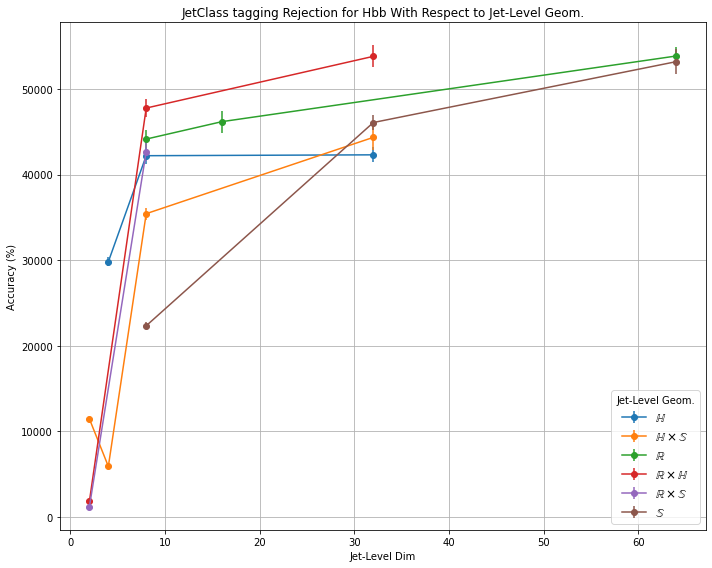

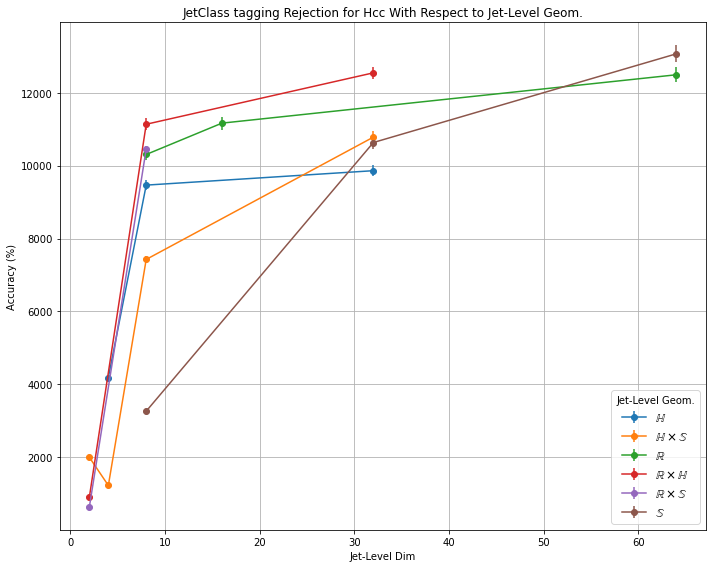

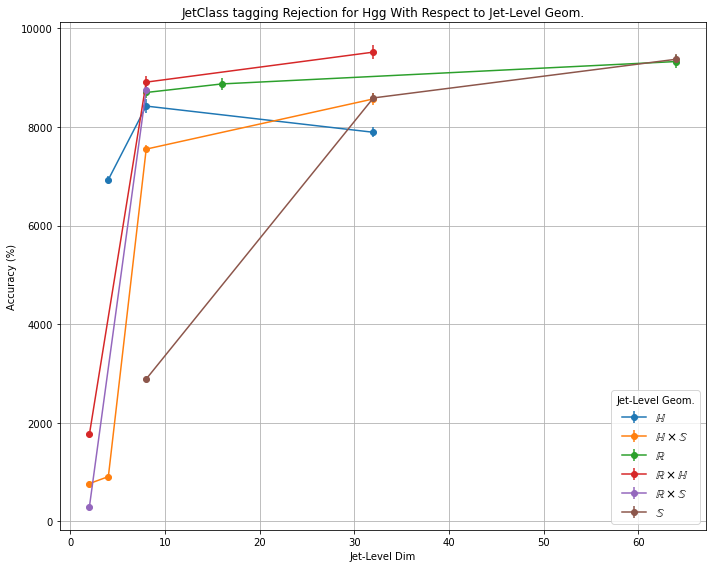

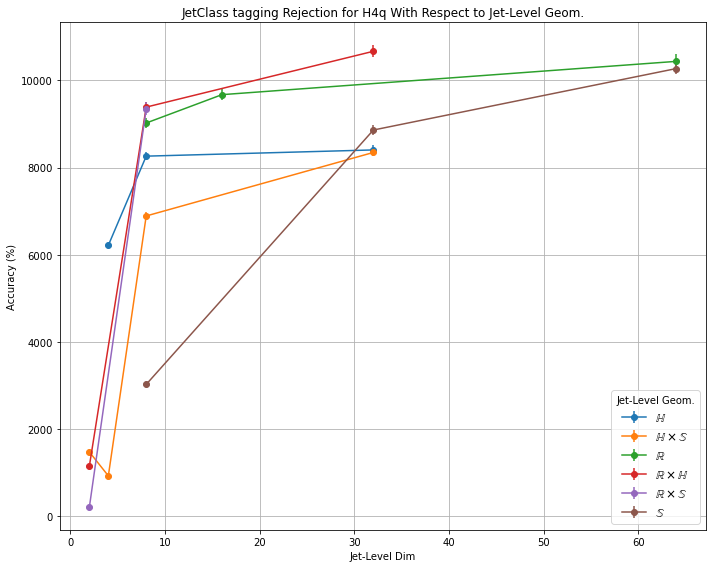

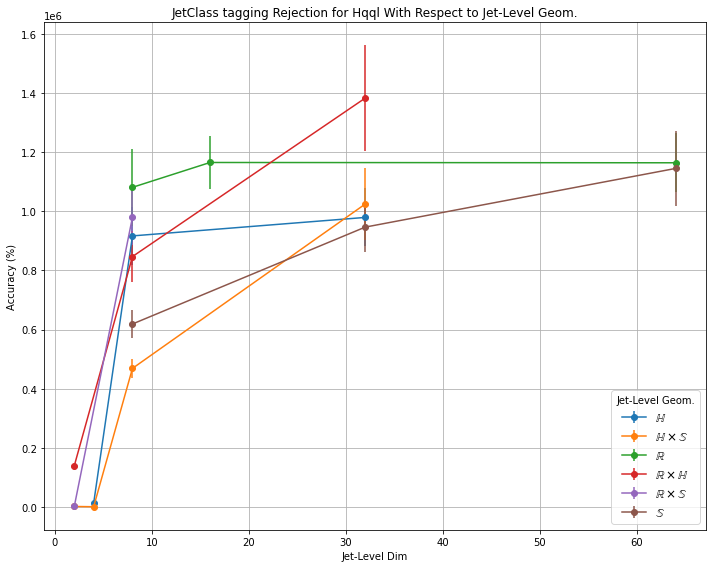

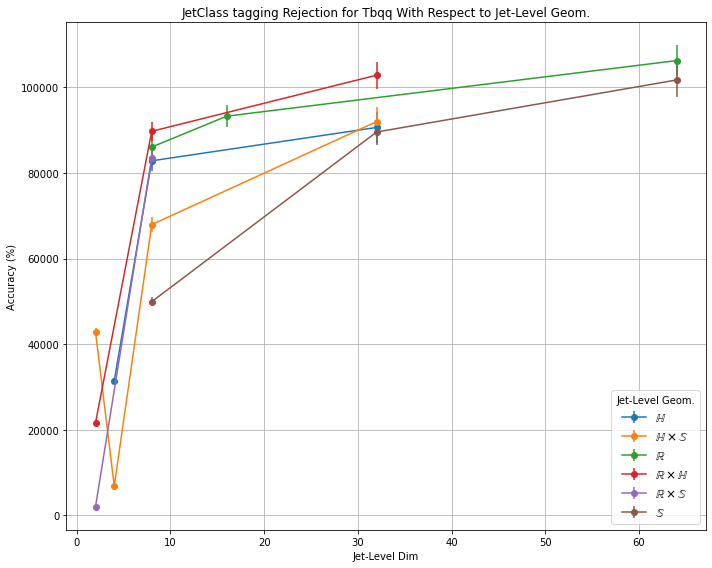

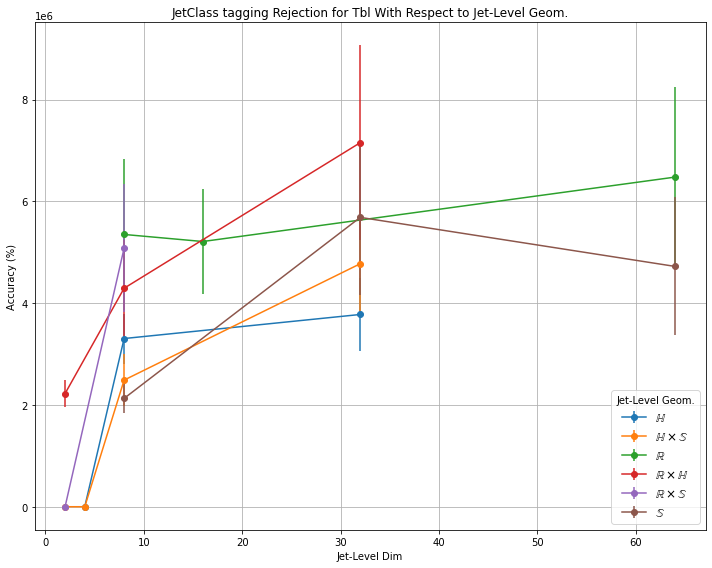

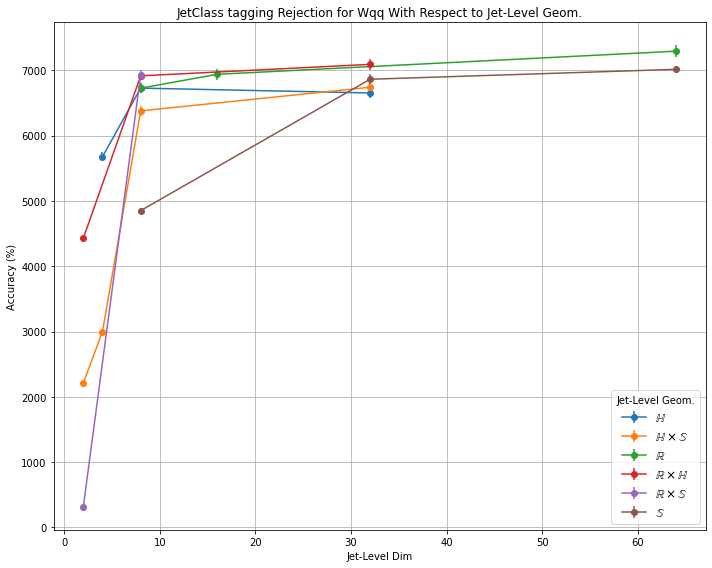

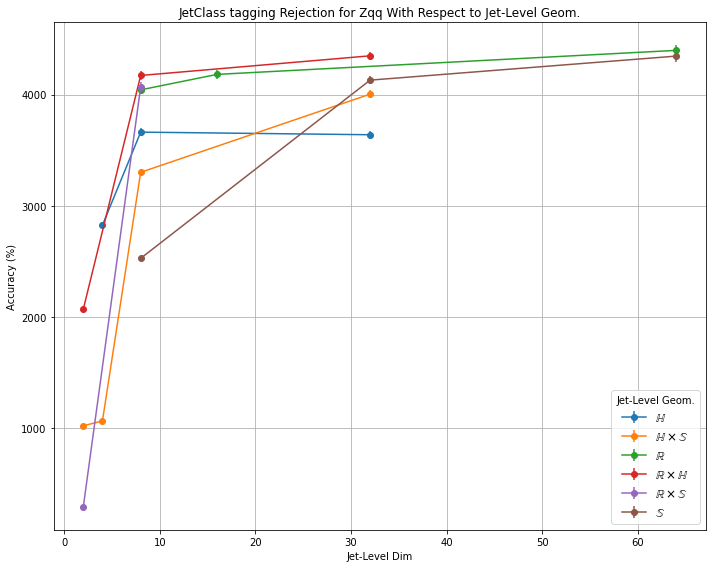

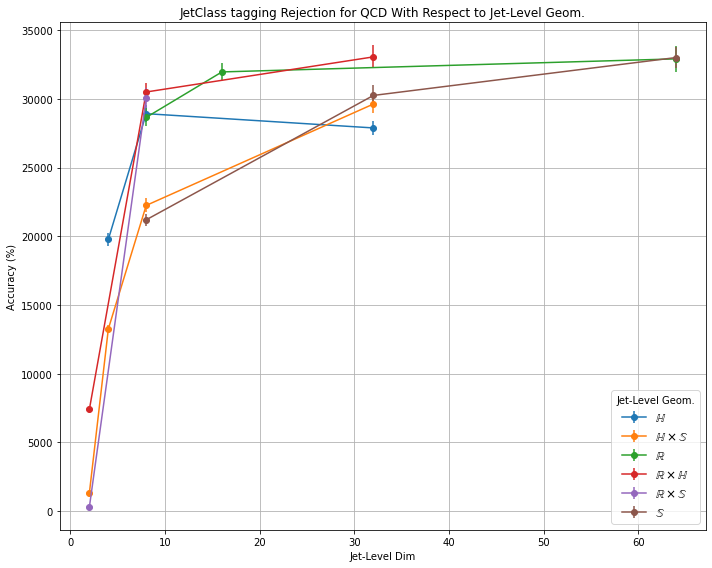

In [5]:
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}

signals = ['Hbb', 'Hcc', 'Hgg', 'H4q', 'Hqql', 'Tbqq', 'Tbl', 'Wqq', 'Zqq', 'QCD']
plot_rejections(results_df,title = 'JetClass tagging',rejection=50,classes = signals, variable_to_vary='jet_dim', filter_values=filter_values)